## SI507 Final Project: Sentiment Analysis on Subreddit r/Obesity Comments
### Objectives
- Comparison with r/fatlogic subreddit
- potentially put in .py file
- generate graphs for all posts or ones with max. no. of nodes
- TooManyRequests: received 429 HTTP response -> don't scrape too many 
- Don't use nutrition data for now
- Walk through interface - Video
- Include findings in README file
- run sentiment analysis over both scraped json files (optional)

#### Approximate Difficulty
- Web API you haven’t used before that requires OAuth: 6
    - https://www.reddit.com/dev/api/
- Nutrition, Physical Activity, and Obesity - Behavioral Risk Factor Surveillance System Data: 2
    - [Data Page](https://catalog.data.gov/dataset/nutrition-physical-activity-and-obesity-behavioral-risk-factor-surveillance-system)

- Sentiment analysis --> feed data from tree directly to perform analyses
- Networkx => save trees in form of .json data
- [PRAW 7.7.1 Documentation](https://praw.readthedocs.io/en/stable/getting_started/quick_start.html)
- [Working with Reddit Comment Trees](https://www.reddit.com/r/datasets/s/c34hswA2td)
- [Creating Reply Networks from Reddit Comment Threads](https://jrashford.com/2022/01/21/creating-reply-networks-from-reddit-comment-threads/)

In [18]:
# imports
import praw
import networkx as nx
import matplotlib.pyplot as plt
import json
import textwrap
import copy
import os
import time
from datetime import datetime

# go to reddit.com/prefs/apps to edit app information
# client_id: freedom_or_chemicals
# sec_key: SuhVQ8O5zPcQ9qw0BSwGsi5pQn_aBQ
# user_agent/APP Name: VnWlWdqCq0If8VbJAqJRzw

In [14]:
# Initialize the Reddit instance with OAuth2 credentials to access Reddit API

# reddit = praw.Reddit(
#     client_id="VnWlWdqCq0If8VbJAqJRzw",
#     client_secret="SuhVQ8O5zPcQ9qw0BSwGsi5pQn_aBQ",
#     user_agent="script for obesity research 1.0",
# )

### Scrape Data via Reddit API (don't need to run if JSON files exist)

In [20]:
# Fetch the top n posts from a given subreddit

# top_comment_list = []

# # define target subreddit for scraping
# subreddit = reddit.subreddit("fatlogic") #r/fatlogic, r/obesity

# for submission in subreddit.top(limit=5):
#     # append submission info into list
#     submission_info = {"submission_id": submission.id, "title": submission.title}
#     top_comment_list.append(submission_info)
#     # time.sleep(100000)

#     # retrieve any comments that may be collapsed
#     submission.comments.replace_more(limit=None)

#     # append comments to list that will be nested
#     comments_for_submission = []
#     for comment in submission.comments.list():
#         # only comment body
#         # other options
#         # .author
#         # .score - upvotes or downvotes
#         # .parent_id
#         comment_info = {
#             "body": comment.body,
#             "timestamp": comment.created_utc,
#             "parent": comment.parent_id,
#             "comment_id": comment.id
#         }
#         comments_for_submission.append(comment_info)
#     # update last position of the list with nested information
#     top_comment_list[-1]["comments"] = comments_for_submission

# # save scraped contents in json file
# with open("json_data/fat_logic_comment_data.json", "w") as json_file:
#     json.dump(top_comment_list, json_file, indent=2)

*It seems that there are API call limitations, so set the post limit to 100 for now.*

In [ ]:
# # Now fetch the newest n posts from a given subreddit
# newest_comment_list = []

# # define target subreddit for scraping
# subreddit = reddit.subreddit("Obesity")

# for submission in subreddit.new(limit=100):
#     # append submission info into list
#     submission_info = {"submission_id": submission.id, "title": submission.title}
#     newest_comment_list.append(submission_info)

#     # retrieve any comments that may be collapsed
#     submission.comments.replace_more(limit=None)

#     # append comments to list that will be nested
#     comments_for_submission = []
#     for comment in submission.comments.list():
#         # only comment body
#         # other options
#         # .author
#         # .score - upvotes or downvotes
#         # .parent_id
#         comment_info = {
#             "body": comment.body,
#             "timestamp": comment.created_utc,
#             "parent": comment.parent_id,
#         }
#         comments_for_submission.append(comment_info)
#     # update list item with nested information
#     newest_comment_list[-1]["comments"] = comments_for_submission

# # save scraped contents in json file
# with open("new_comment_data.json", "w") as json_file:
#     json.dump(newest_comment_list, json_file, indent=2)

### Create Trees from JSON Data for Each Post

In [2]:
def buildCommentTree(comments):
    tree = []
    di = {}

    # create a deep copy of the comments list
    comments_copy = copy.deepcopy(comments)

    # create a dictionary with key-value pairs using the unique comment IDs as keys
    for comment in comments_copy:
        di[comment['comment_id']] = comment

    for comment in comments_copy:
        comment_id = comment['comment_id']
        # remove the t3 or t1 prefixes from parent IDs
        parent_id = comment['parent'][3:]

        # Check if the comment is a top-level comment
        # the parents of top-levels posts are the post itself, and therefore not present here
        if parent_id not in di:
            tree.append(di[comment_id])
        else:
            parent = di[parent_id]
            if "comments" not in parent:
                parent["comments"] = []
            parent["comments"].append(di[comment_id])

    return tree

In [3]:
# Load JSON data from file (obesity)
with open("json_data/top_comment_data.json", "r") as file:
    data = json.load(file)

In [24]:
# Load JSON data from file (fatlogic)
with open("json_data/fat_logic_comment_data.json", "r") as file:
    data = json.load(file)

In [25]:
# replace the 'comments' part of the data with organized trees
for post in data:
    post['comments'] = buildCommentTree(post['comments'])

### Plot the Tree Structures with NetworkX

In [26]:
# eliminate posts with no comments and retain those with 1 or more comments
posts_with_comments = [post for post in data if 'comments' in post and post['comments']]

In [27]:
# get the number of posts with 1 or more comments
len(posts_with_comments)

5

In [7]:
def convert_timestamp(timestamp):
    return datetime.utcfromtimestamp(timestamp).strftime('%Y-%m-%d')

def splitTitle(title, max_width=75):
    '''breaks up post titles that are too long
    '''
    # Use textwrap to wrap the title at spaces
    wrapped_title = textwrap.fill(title, width=max_width)
    return wrapped_title

In [8]:
def add_nodes_and_edges(G, comment):
    # Recursively add nodes and edges for comments and their replies
    for reply in comment.get("comments", []):
        G.add_node(reply["comment_id"], label=convert_timestamp(reply["timestamp"]), color="cadetblue")  # Set other nodes color to blue
        G.add_edge(comment["comment_id"], reply["comment_id"])
        add_nodes_and_edges(G, reply)

In [33]:
def plotGraph(post_data):
    G = nx.DiGraph()

    # add root node for the post
    root_id = post_data["submission_id"]
    G.add_node(root_id, label=root_id, color="palevioletred")  # set root node color to red

    # add edges from the post to top-level comments
    for comment in post_data.get("comments", []):
        # set color for nodes surrounding root node
        G.add_node(comment["comment_id"], label=convert_timestamp(comment["timestamp"]), color="cadetblue")
        G.add_edge(root_id, comment["comment_id"])
        add_nodes_and_edges(G, comment)

    # plot graph, ADJUST LAYOUT HERE
    pos = nx.planar_layout(G)

    # get node colors based on 'color' attribute
    node_colors = [G.nodes[node]["color"] for node in G.nodes]

    # get node labels based on 'label' attribute
    node_labels = {node: G.nodes[node]["label"] for node in G.nodes}

    nx.draw(
        G,
        pos,
        labels=node_labels,
        with_labels=True,
        font_size=8,
        node_size=100,
        font_color="black",
        node_color=node_colors,
        edge_color="gray",
        font_weight="bold",
    )

    # save the plot with the post title (optional, can change basis for saving)
    plt.title(splitTitle(post_data["title"]))
    folder_path = "plot_graphs"
    os.makedirs(folder_path, exist_ok=True)  # Create the folder if it doesn't exist
    file_path = os.path.join(folder_path, f"{post_data['submission_id']}_graph.png")
    # print(file_path)
    # plt.savefig(file_path)
    plt.show()

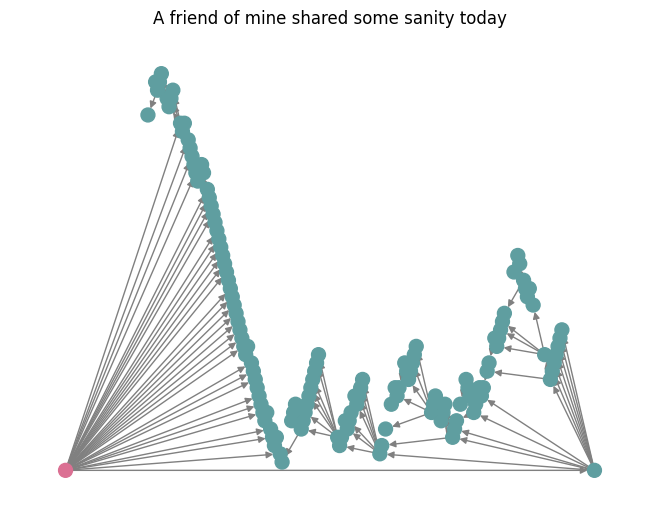

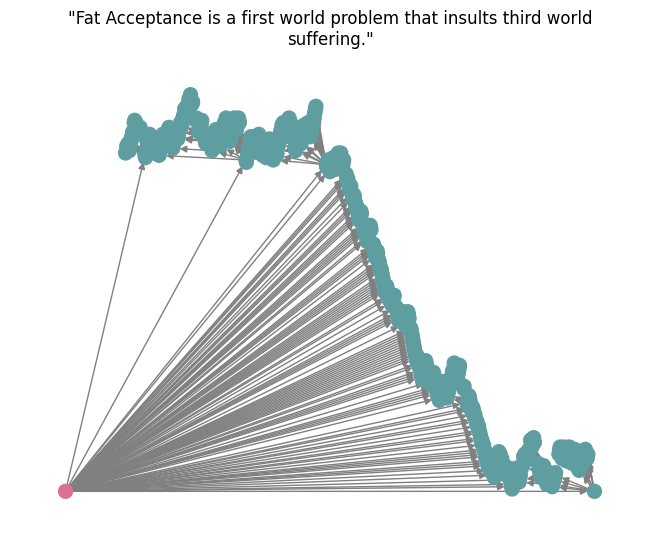

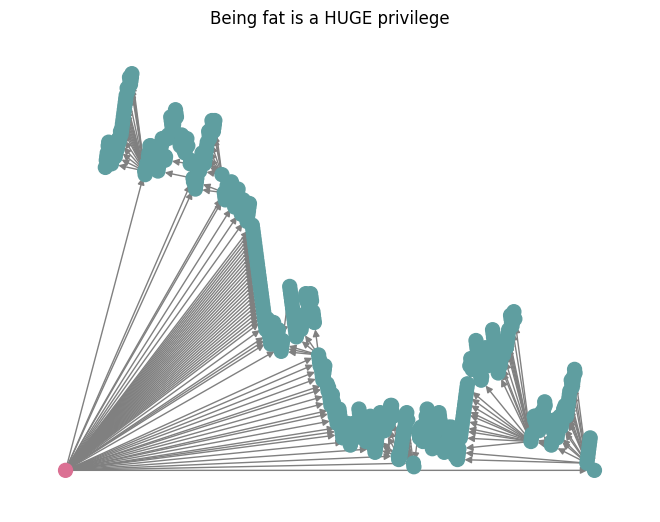

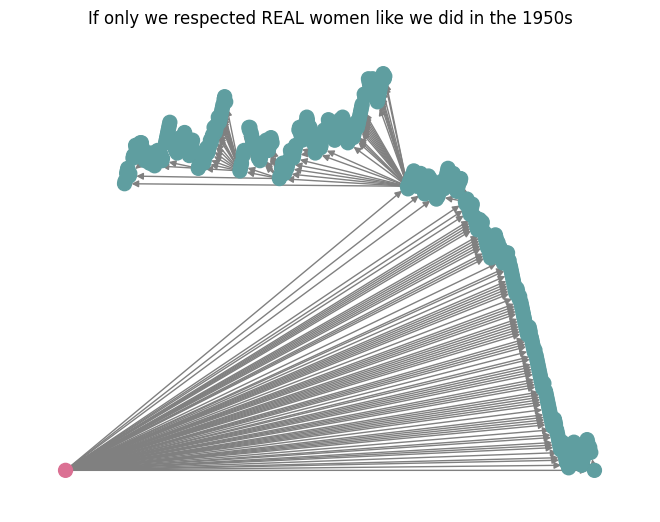

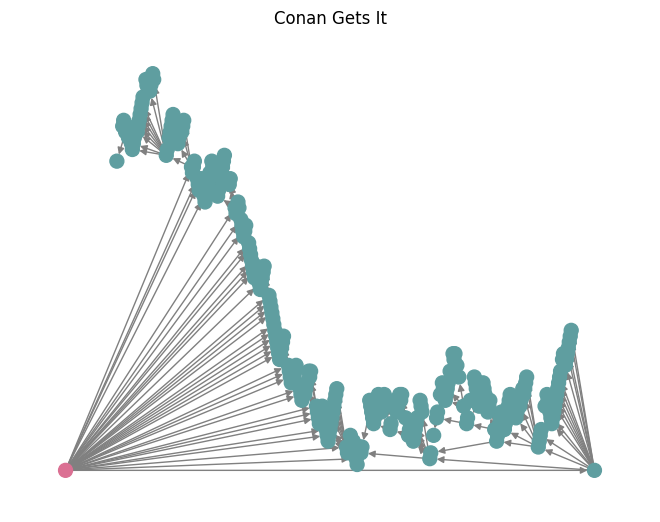

In [34]:
for p in posts_with_comments:
    plotGraph(p)